In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sys
sys.path.append('..')

from astroLuSt.database_interface import alerceinterface as aldiai
from astroLuSt.database_interface import eleanorinterface as aldiei
from astroLuSt.database_interface import gaiainterface as aldigi
from astroLuSt.database_interface import lightkurveinterface as aldili
from astroLuSt.database_interface import simbadinterface as aldisi

import importlib
importlib.reload(aldiai)
importlib.reload(aldiei)
importlib.reload(aldigi)
importlib.reload(aldili)
importlib.reload(aldisi)

#style for plotting
plt.style.use('astroLuSt.styles.LuSt_style')



2023-12-25 18:46:01.359320: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
targets = [
    'KIC 5006817', 'RR Lyr', 'TV Boo', 'KIC 5006817'
]

# SimbadDatabaseInterface

In [3]:
importlib.reload(aldisi)

SDI = aldisi.SimbadDatabaseInterface(
    simbad_timeout=120,
    npartitions=1,
    verbose=3,
)
print(SDI)
df_ids = SDI.extract_ids(
    input_ids=targets,
    show_scanned_strings_at=[1],
    verbose=None,
    parallel_kwargs=dict(n_jobs=4),
)

tics = df_ids['TIC']
print(tics)

df_ids

SimbadDatabaseInterface(
    npartitions=1,
    simbad_timeout=120,
    verbose=3,
)
INFO(extract_ids): Working on partition 1/1
INFO(match_ids_): Catalog is `None`. Corresponding id: `"KOI-5112"`
    INFO(match_ids_): Scanned Target: RR Lyr
    INFO(match_ids_): Query Result: HD 182989|AG+42 1698|AN   34.1901|AP J19252793+4247040|ASCC  425414|BD+42  3338|GAT  791|GC 26836|GCRV 11873|GEN# +1.00182989|G 125-7|GSC 03142-00494|HIC  95497|HIP 95497|KIC 7198959|LSPM J1925+4247|LTT 15677|2MASS J19252793+4247040|NLTT 47799|NSVS   5543125|PLX 4550|PLX 4550.00|PPM  58291|SAO  48421|SKY# 36151|SV* HV   180|TD1 24704|TIC 159717514|TYC 3142-494-1|USNO-B1.0 1327-00425262|USNO 886|uvby98 100182989|V* RR Lyr|WEB 16701|Gaia DR3 2125982599343482624|Gaia DR2 2125982599341232896
INFO(match_ids_): Catalog is `None`. Corresponding id: `"G 125-7"`
0    122447138
1    159717514
2    168709463
Name: TIC, dtype: object


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   3 out of   3 | elapsed:    0.0s finished


,input_id,main_id,ra,dec,TYC,AP,KIC,2MASS,TIC,Gaia DR3,...,SV* HV,TD1,USNO-B1.0,USNO,uvby98,V* RR,WEB,CSI,uvby98 650902022,V* TV
0,KIC 5006817,KOI-5112,19 21 49.4321,+40 08 44.635,3138-1561-1,J19214942+4008446,5006817,J19214942+4008446,122447138,2101103743584479744,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,RR Lyr,V* RR Lyr,19 25 27.9129,+42 47 03.693,3142-494-1,J19252793+4247040,7198959,J19252793+4247040,159717514,2125982599343482624,...,180,24704,1327-00425262,886,100182989,Lyr,16701,NaN,NaN,NaN
2,TV Boo,V* TV Boo,14 16 36.5814,+42 21 35.712,3038-699-1,J14163658+4221356,NaN,J14163658+4221356,168709463,1492230556717187456,...,NaN,NaN,NaN,NaN,NaN,NaN,12148,+42-14146,V,Boo


# EleanorDatabaseInterface

INFO(EleanorDatabaseInterface.download()): Extracting chunk 1/1 (0/2)


[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.


{'gaia': '114797397716085120'}
Traceback (most recent call last):
  File "/home/lukas/github/astroLuSt/demos/../astroLuSt/database_interface/eleanorinterface.py", line 326, in extract_source
    star = eleanor.multi_sectors(
  File "/home/lukas/venvs/astroLuSt/lib/python3.10/site-packages/eleanor/source.py", line 78, in multi_sectors
    star = Source(tic=tic, gaia=gaia, coords=coords, sector=int(s), tc=tc,
  File "/home/lukas/venvs/astroLuSt/lib/python3.10/site-packages/eleanor/source.py", line 262, in __init__
    self.locate_on_tess()
  File "/home/lukas/venvs/astroLuSt/lib/python3.10/site-packages/eleanor/source.py", line 304, in locate_on_tess
    arg = np.argwhere(sectors == self.usr_sec)[0]
IndexError: index 0 is out of bounds for axis 0 with size 0


No eleanor postcard has been made for your target (yet). Using TessCut instead.


/home/lukas/github/astroLuSt/demos/../astroLuSt/monitoring/errorlogging.py:172: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self.df_errorlog = pd.concat([self.df_errorlog, df_temp])


No eleanor postcard has been made for your target (yet). Using TessCut instead.


[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    4.3s finished
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


[array(['time', 'raw_flux', 'flux_err', 'corr_flux', 'quality', 'sector',
       'tess_mag', 'aperture_size', 'raw_flux_normalized',
       'corr_flux_normalized', 'pca_flux', 'pca_flux_normalized'],
      dtype='<U20'), array(['time', 'raw_flux', 'flux_err', 'corr_flux', 'quality', 'sector',
       'tess_mag', 'aperture_size', 'raw_flux_normalized',
       'corr_flux_normalized', 'pca_flux', 'pca_flux_normalized'],
      dtype='<U20')]


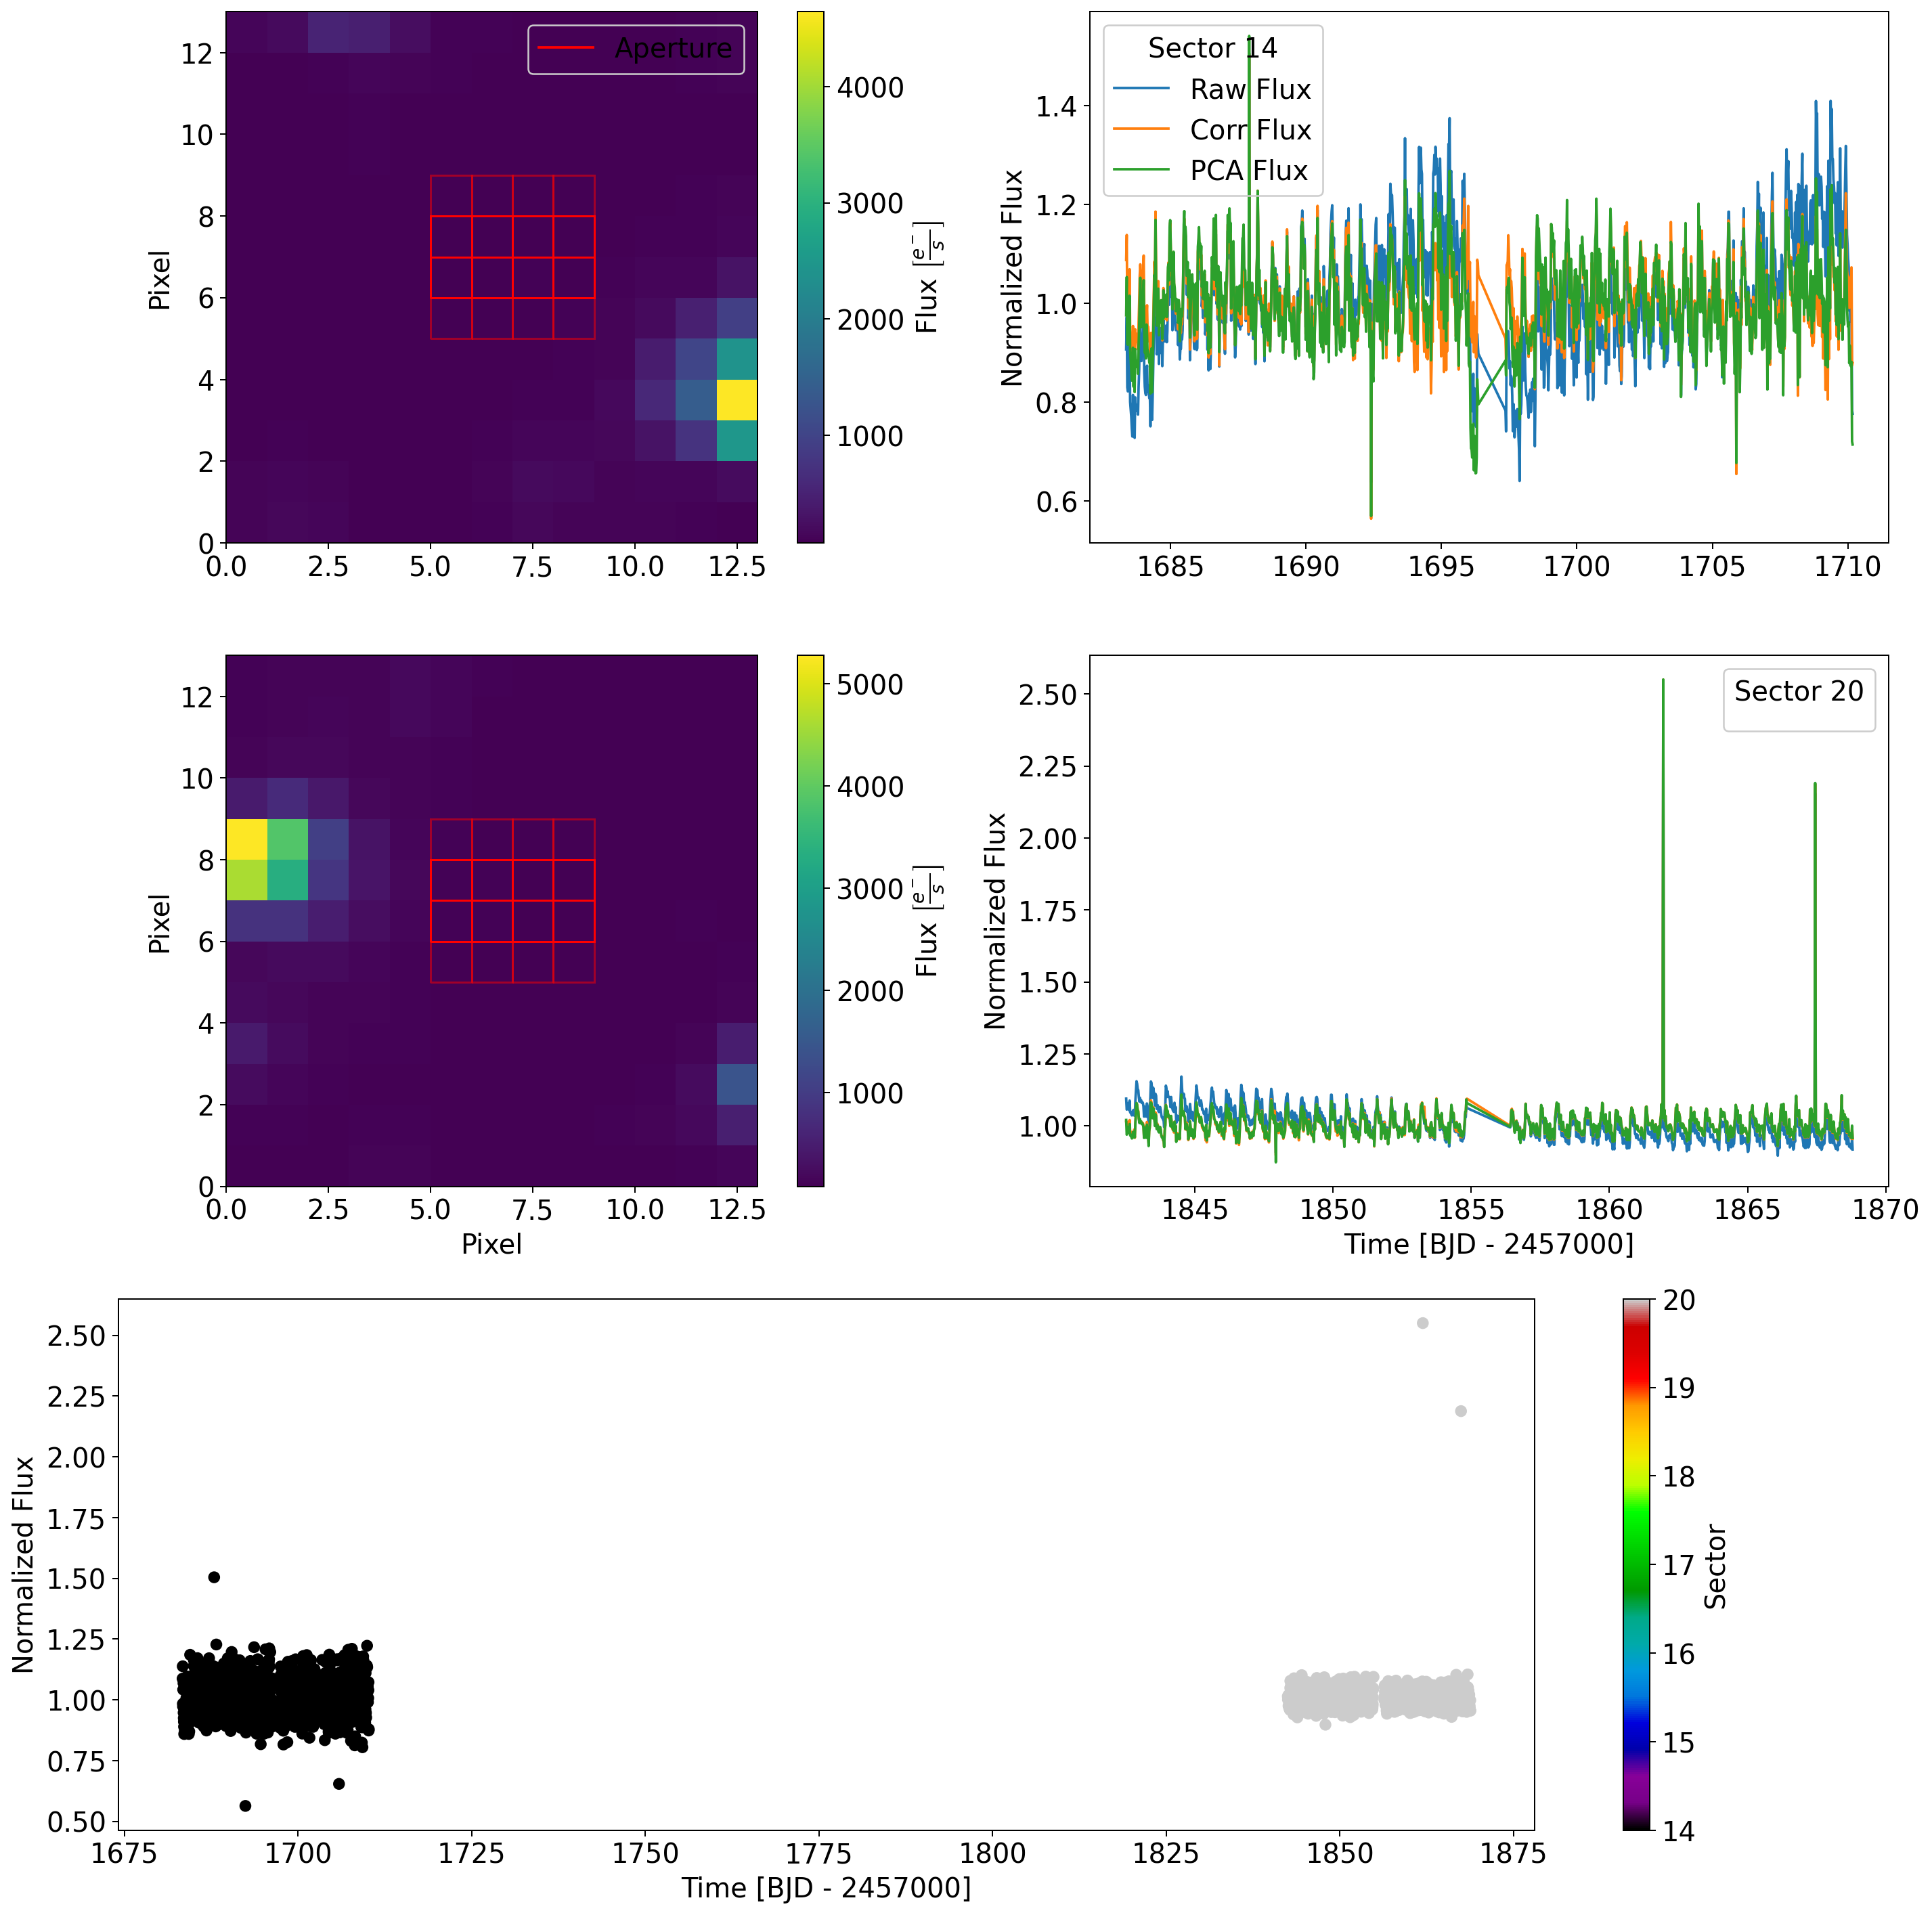

In [32]:
importlib.reload(aldiei)

EDI = aldiei.EleanorDatabaseInterface(
    n_jobs=2,
    redownload=True,
    verbose=3,
)

lcs, headers, tpfs, aperture_masks = EDI.download(
    sectors=[14,20],
    # sectors='all',
    # source_ids=[{'tic':tic} for tic in tics[:]],
    # source_ids=[{'gaia': '2249474965068982272'}],
    source_ids=[{'gaia': '2249474965068982272'}, {'gaia': '114797397716085120'}],
    get_normalized_flux=True, normfunc=lambda x: x/np.nanmedian(x),
    tpfs2store=slice(1), store_aperture_masks=True,
    # tpfs2store=None, store_aperture_masks=True,
    n_chunks=1,
    targetdata_kwargs=dict(do_pca=True, aperture_mode='small'),
    custom_aperture_kwargs=dict(shape='rectangle', h=3, w=4), #in case you want to use a custom aperture
    save_kwargs=dict(directory='./data/', pd_savefunc='to_parquet'),
)

print(headers)
fig, axs = EDI.plot_result(
    lcs=lcs[0],
    headers=headers[0],
    tpfs=tpfs[0],
    aperture_masks=aperture_masks[0],
)

plt.show()




# GaiaDatabaseInterface

In [ ]:
GID = aldigi.GaiaDatabaseInterface()
GID.gaia_crendetials = "../credentials_gaia.txt"

filter = "(jobs['phase'] == 'ERROR')"
GID.remove_all_jobs(pd_filter=filter, login_before=False, logout_after=False)


# AlerceDatabaseInterface

In [ ]:
importlib.reload(aldiai)

ADI = aldiai.AlerceDatabaseInterface()

df = pd.DataFrame(
    data=np.array([
        [10054,	12.39495833, 27.02213889,],
        # [10088,	353.7751667, np.inf,],#41.10291667,],
        [10140,	16.294625,	 34.21841667,],
        # [10147,	359.6756667, 41.48880556,],
    ]),
    columns=['id', 'ra', 'dec']
)

df_ztf = ADI.crossmerge_by_coordinates(
    df_left=df,
    ra_colname='ra', dec_colname='dec', radius=1,
    sleep=2E-3,
    n_jobs=1, verbose=2
)

print(ADI.df_error_msgs_crossmerge)

ADI.download_lightcurves(
    df_ztf['oid_ztf'],
    save=False,
    # save='./data/',
    redownload=False,
    plot_result=True, save_plot=False, close_plots=False,
    sleep=2E-3,
    n_jobs=1, verbose=2
)
print(ADI.df_error_msgs_lcdownload)

# LightkurveInterface

In [ ]:

importlib.reload(aldili)
LKI = aldili.LightkurveInterface(
    tics=tics.astype(np.float64)
)

LKI.download_lightcurves_tess(
    #saving data
    save=False,
    sectors='all',
    quality_expression="(datum.quality == 0)",
    include_aperture=False, include_tpf=False,
    #plotting
    plot_result=True,
    aperture_detail=50, ylims=None,
    fontsize=16, figsize=(16,9),
    save_plot=False,
    sleep=0,
    n_jobs=1, n_chunks=1,
    verbose=2
)

print(LKI.df_extraction_summary)